# Data scaling heuristics for quantum machine learning

## The problem of data scaling in quantum machine learning

In many machine learning algorithms, it is necessary to scale the data to a standard format in order to get good performance. Quantum machine learning is certainly not immune from this, and suffers from this issue particularly strongly. To illustrate this, we will set up a simple 1D regression problem. 

First we define some data using a simple sinusoid function plus some noise:

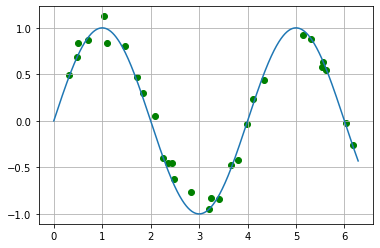

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(2022)


def generate_data_regression(inputs: np.ndarray, noise: float = 0, freq=2 * np.pi / 10):
    """Function used to generate noisy data."""
    data = np.sin(freq * inputs)
    # add some random noise to data
    noisy_data = data + np.random.normal(0,noise,len(data))
    return data, noisy_data

points = np.arange(0, 2*np.pi, 0.01)
X = np.random.choice(points,30,replace=False)

freq= np.pi/2
labels, Y = generate_data_regression(X, noise=0.1,freq=freq)

# Plot data
x_points = np.linspace(0, 2*np.pi, 1000)

plt.scatter(X, Y, color="green")

plt.plot(x_points, np.sin(freq * x_points))
plt.grid()
plt.show()

We will try to fit this data using a simple 1D quantum model. We will use JAX to speed things up.

In [2]:
import jax
import jax.numpy as jnp
import pennylane as qml

dev = qml.device("default.qubit", wires=1)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights,input_data):
    qml.RX(weights[-1],wires=0)
    for layer in range(len(weights)):
        qml.RX(input_data,wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,0)) #the vectorised circuit

In [3]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

def cost(params, input_data, labels):
    """Cost function."""
    predictions = vcircuit(params['w'], input_data)
    return square_loss(labels, predictions) 

To optimise the model we make use of optax, an optimisation package for JAX.

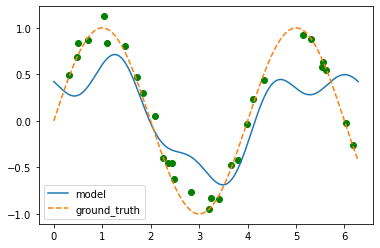

Iter:   991 | Cost: 0.1194743


In [4]:
import optax
from IPython.display import clear_output

layers=3
lr=0.1 #learning rate
params = {'w': np.random.rand(layers+1)} 
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

for it in range(1000):
    cst, grads = jax.value_and_grad(cost)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)    
    model_plot = vcircuit(params['w'], x_points)
    
    if it%10==0:
        clear_output(wait=True)
        plt.plot(x_points,model_plot,label='model')
        plt.plot(x_points, np.sin(freq * x_points),linestyle='dashed',label='ground_truth')
        plt.scatter(X, Y, color="green")
        plt.legend()
        plt.show()
        print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")


We can see that the quantum model struggles to find a frequency that matches the data. This is because quantum machine learning models can be written as a truncated fourier series

$$f_w(x)=\sum_{w\in\Omega}c_w(\omega)e^{i \omega\cdot x}.$$

The avaliable frequencies $\Omega$ depend on the eigenvalue structure of the data encoding gates and the number of times the data is encoded into the circuit. In our case we have 

$$\Omega = \{-L,-L+1,\cdots,L-1,L\}$$

where $L$ is the number of layers. Since our data was sampled from a sin wave with frequency $\pi/2$, the quantum model does not have access to this frequency as it can only access integer values. 

To try and remedy this situation we will introduce some new trainable parameters called ``scalings`` that *scale* the data. In principle, this gives the model access to all possible frequencies.

In [5]:
dev = qml.device("default.qubit", wires=1)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights,scalings,input_data):
    "new model with data scaling"
    qml.RX(weights[-1],wires=0)
    for layer in range(len(weights)):
        qml.RX(input_data*scalings[layer],wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,None,0)) #the vectorised circuit

def cost(params, input_data, labels):
    """Cost function."""
    predictions = vcircuit(params['w'],params['s'], input_data)
    return square_loss(labels, predictions) 

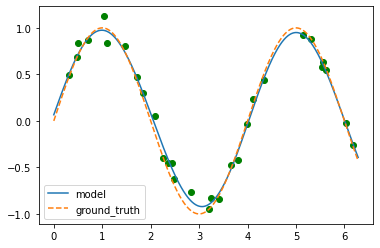

Iter:   991 | Cost: 0.0049153


In [6]:
def optimise_model(params,X,Y,lr=0.01,initial_scaling=1.0):
    params = {'w': np.random.rand(layers+1),'s': np.ones(layers)*initial_scaling} 
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    for it in range(1000):
        cst, grads = jax.value_and_grad(cost)(params, X, Y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)    
        model_plot = vcircuit(params['w'],params['s'], x_points)

        if it%10==0:
            clear_output(wait=True)
            plt.plot(x_points,model_plot,label='model')
            plt.plot(x_points, np.sin(freq * x_points),linestyle='dashed',label='ground_truth')
            plt.scatter(X, Y, color="green")
            plt.legend()
            plt.show()
            print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")

optimise_model(params,X,Y)

With this greater expressivity, the model is able to find a good fit to the data. However, with great expresivity comes great power. In a general learning problem, we will not know the frequency of the data, and the initial value of the scaling may be poorly matched with the frequency of the data. For example, let's run the same optimisation but with a larger initial scaling of the data. 

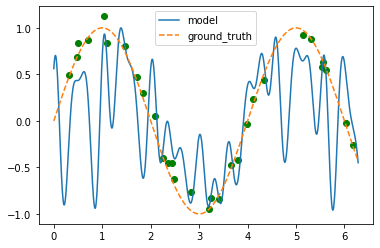

Iter:   991 | Cost: 0.1050625


In [8]:
optimise_model(params,X,Y,initial_scaling=6,lr=0.1)

The model now cannot find a good fit to the data, and shows signs of overfitting. In fact, this is somewhat to be expected, since it is known that such a model has [inifinite VC dimension](https://meticulousdatascience.com/journal/vc-dimension.html).

This small investigation points to two things:
- Introducing trainable parameters to scale the data seems to be a good idea for QML models
- One needs a method to set the initial data scale so that the frequency of the QML model matches that of the data

In the rest of this notebook we will look at methods to tackle the second point above. 

Note that one could also add regularisation to the scaling parameters to control the complexity of the model. This works quite well, although one still has the problem of how to decide how large the regularisation parameter should be, which is still related to the frequency scale of the data. 


## Scaling data via the discrete fourier transform

A simple way to try and get frequency information from the data is to use the discrete fourier transform (DFT). To use the DFT, we need to have equally spaced data, so we will work with data of the form $\{x_i,f(x_i)\}$ where $x_i=0,1,\cdots,N-1$. The (centered) DFT for $N$ equally space data 

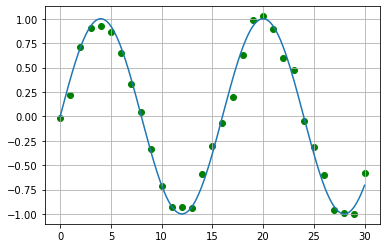

In [9]:
X = np.arange(0, 31, 1) #equally spaced data

freq= np.pi/8
labels, Y = generate_data_regression(X, noise=0.1,freq=freq)

# Plot data
x_points = np.linspace(0, 30, 1000)

plt.scatter(X, Y, color="green")

plt.plot(x_points, np.sin(freq * x_points))
plt.grid()
plt.show()

The (centered) DFT is 
$$F(w) = \sum_{x=0}^{N-1}f(x)e^{-2\pi i (\omega-(N-1)/2)(x-(N-1)/2)/N}.$$
We can recover the original data values with the inverse transform
$$f(x) = \sum_{w=0}^{N-1}F(x)e^{-2\pi i (\omega-(N-1)/2)(x-(N-1)/2)/N}.$$

Let's apply the DFT to our data and look at the frequency spectrum:

Text(0.5, 0, 'frequency')

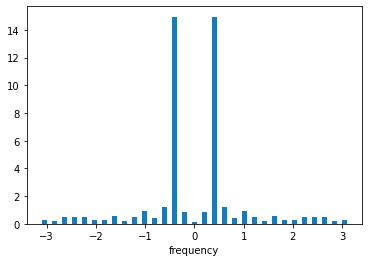

In [12]:
def centered_dft(data):
    "computes the centered dft of a list of data values"
    N=len(data)
    M = np.array([[np.exp(-2j * np.pi * (i - (N - 1) / 2) * (j - (N - 1) / 2) / N) for i in range(N)] for j in range(N)])
    dft=np.matmul(M,data)
    return dft

Y_dft = centered_dft(Y)
freqs = np.arange((-len(Y)-1)/2+1,(len(Y)-1)/2+1,1)*2*np.pi/len(Y)

plt.bar(freqs,np.abs(Y_dft),width=0.1)
plt.xlabel('frequency')

We see a peak at around 0.5, which corresponds to a frequency of $2\times2\pi /N \approx \pi/8$ as expected, and frequencies highger than this do not play a role. Since the max frequency of the quantum model is $L$, this analysis suggests we should chose a data scaling $\gamma$ such that
$$\gamma L = 0.5$$
in order to match the data to the  frequency of the model. Lets do that (for $L=3$, so $\gamma=1/12$) and see how it performs:

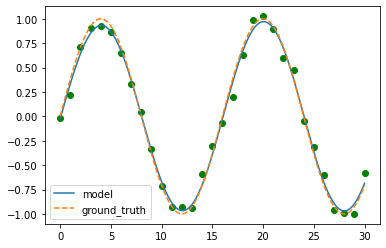

Iter:   991 | Cost: 0.0047734


In [13]:
optimise_model(params,X,Y,initial_scaling=1/12,lr=0.01)

With this initialisation, the model easily finds the correct fit. 

## A scalable heuristic for regression via random fourier features

Although the DFT works well for the above example, there are two problems with scaling the method up to general problems:

- Most data is not evenly spaced, so one cannot use the standard DFT on it
- Computing the full multivariate DFT scales exponentially with the dimension of the data

We therefore need a scalable method to extract freqency information from unevenly spaced data. To do this we will use a cool trick that links kernel regression and fourier models, known as *random fourier feature models*. 

A kernel regression model is a model of the form 
$$f_{\vec{\beta}}(x) = \sum_i \beta_i K(x_i,x)$$
where $K$ is a kernel function. There is a beautiful result, called Bochner's theorem, that links stationary kernels to fourier series:

*Bochner's theorem:* A continuous stationary kernel $K(x,y)=K(x-y)$ is positive definite if and only if 
$K(\Delta)$ is the Fourier transform of a non-negative measure. i.e.

$$K(\Delta)=\int p(\omega)e^{i\omega\Delta}d\omega.$$

For the famous radial basis function kernel $K(x,y)=e^{-\frac{1}{2}(x-y)^2}$ the corresponding distribution is a multivariate Gaussian with the identity covariance matrix. We can approximate the kernel model as 

$$f_{\vec{\beta}}(x) \approx \sum_i \beta_i \frac{1}{R}\sum_{j=1}^{R}\exp(-i\omega_j\cdot x_i)\exp(i\omega_j\cdot x)$$

where the $\omega_j$ are sampled from a uncorrelated mulivariate Gaussian distribution. The above model is just a linear model in the random fourier feature vectors 

$$\phi(x) = (\exp(i \omega_j \cdot x))_j.$$




Our strategy will therefore be as follows:
- Fit a linear model using a random fourier feature mapping
- Extract frequency information about the data from the weights of the fitted model

Intuitively, if the fourier features model but a large weight on a certain frequecy range, then it is likely to relevant to the quantum machine learning model as well. 

One last thing before we get training: to fit the fourier model we will use **Lasso regression**, which outputs a sparse weight vector, and therefore highlights only the most important frequencies. In practice we have found that this reveals much more relevant information than standard linear or reidge regression. 

### An example in 3 dimensions
Let's look at a data set with 3 dimension. We will generate it in a similar way to before, by generating a random fourier series:

In [14]:
NUM_POINTS = 5000
NUM_DIMENSIONS = 3
CUSTOM_DATASET = False

def generate_non_uniform_fourier_series(num_frequencies: int, max_frequency: float):
    """Generate function f(x) that returns a sum of cosines with
    random amplitudes, frequencies and phases."""
    
    frequencies = [max_frequency * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    amplitudes = [np.random.random() for _ in range(num_frequencies)]
    phases = [2 * np.pi * np.random.random() for _ in range(num_frequencies)]
    print(f"Frequencies: {frequencies}")
    print(f"Amplitudes: {amplitudes}")
    print(f"Phases: {phases}")
    def f(x: np.ndarray):
        res = 0
        for frequency, amplitude, phase in zip(frequencies, amplitudes, phases):
            res += 1 * np.cos(np.dot(x, frequency) + phase)
        return res
    return f, frequencies

def generate_regression_data(inputs: np.ndarray, noise: float = 0):
    """Function used to generate noisy data."""
    data = np.array([f(input) for input in inputs])
    # add some random noise to data
    noisy_data = data + np.random.normal(0, noise, data.shape)
    return data, noisy_data

MAX_FREQUENCY = 4
f, freqs = generate_non_uniform_fourier_series(num_frequencies=3, max_frequency=MAX_FREQUENCY)
X = np.random.random((NUM_POINTS, NUM_DIMENSIONS)) 
labels, Y = generate_regression_data(inputs=X, noise=0.1)


Frequencies: [array([0.4073866 , 1.33547431, 1.24924752]), array([0.4023853 , 1.22589577, 2.06861565]), array([2.53600208, 0.35647239, 0.06935017])]
Amplitudes: [0.019493422286941398, 0.8371912863107542, 0.6151572969467167]
Phases: [5.107724621903526, 4.159657622081755, 6.126528763426005]


To implement random fourier features and Lasso regression we will make use of scikit-learn

In [15]:
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

gamma = 100 #scaling of the Gaussian when sampling random fourier vectors
ndim = 5000 #number of features

#generate the random frequency vectors and apply to the input data 
rbf_feature = RBFSampler(gamma=gamma, n_components=ndim, random_state=1)
X_features = rbf_feature.fit_transform(X)
fourier_weights = rbf_feature.random_weights_

Now let's do the Lasso regression. We will reduce the regression parameter until we have at least 10 frequencies that have non-zero weight in the model. 

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.33, random_state=42)
non_zero_coeffs = []
alpha = 1
MAX_NUM_FREQUENCIES = 10
while len(non_zero_coeffs) < MAX_NUM_FREQUENCIES:
    clear_output(wait=True)
    alpha /= 1.5
    print(f"alpha = {alpha}")
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, Y_train)
    betas = clf.coef_
    non_zero_coeffs = betas[betas != 0]

print(f"Fitting score: {clf.score(X_test, Y_test)}")
print(f"Mean squared error: {mean_squared_error(clf.predict(X_test), Y_test)}")
print(f"Number of non-zero coefficients: {len(non_zero_coeffs)}")

alpha = 0.0006766394845988645
Fitting score: 0.9262779655367699
Mean squared error: 0.03962609086710032
Number of non-zero coefficients: 12


Let's take a look at the feature weights of the random fourier frequencies in each dimension

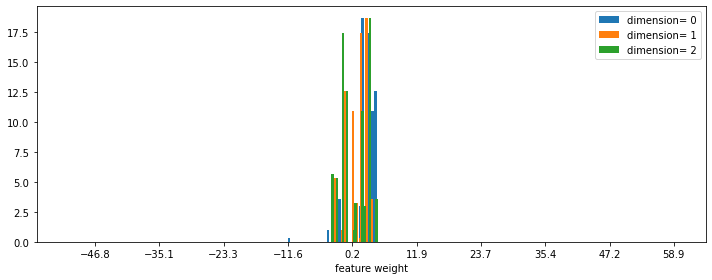

In [17]:
plt.figure(figsize=(10, 4))
for dimension in range(3):
    plt.xticks(np.linspace(np.min(fourier_weights[dimension]), np.max(fourier_weights[dimension]), 10))
    plt.bar(fourier_weights[dimension], np.abs(betas), width=0.5,label='dimension= '+str(dimension))
    plt.tight_layout()
    plt.xlabel('frequency')
    plt.xlabel('feature weight')
    plt.legend()

We see that the lasso regression has highlighted a relevant frequecnt range to be around $\pm 5$. This agrees well with the frequencies used to generate the data and therefore is a good guess at the initial data scaling as required. 


We can automate this process by selecting the max frequency with a weight larger than ``REL_THRESHOLD`` tiesm the max weight over all frequencies. 

In [18]:
REL_THRESHOLD = 0.2
indices = np.abs(betas) >= np.max(np.abs(betas)) * REL_THRESHOLD
betas = betas[indices]
fourier_weights = fourier_weights[:, indices]

cutoff_frequencies = np.max(np.abs(fourier_weights), axis=1)
print(f"Cutoff freqs: {cutoff_frequencies}")
if CUSTOM_DATASET:
    print(f"Maximum freqs: {np.max(freqs, axis=0)}")

Cutoff freqs: [4.41572189 2.99934943 3.49304493]


## Applying the method to real world data